In [1]:
!pip install pyyaml
!pip install dndice
!pip install python-i18n
!pip install gymnasium
!pip install inflect
!pip install collections-extended
!pip install openai
!pip install -e ..
!pip install ipywidgets
!pip install iprogress


Obtaining file:///home/jedld/workspace/natural_20.py
  Preparing metadata (setup.py) ... done
  Attempting uninstall: natural20.py
    Found existing installation: natural20.py 0.1
    Uninstalling natural20.py-0.1:
      Successfully uninstalled natural20.py-0.1
  Running setup.py develop for natural20.py


In [2]:
from gymnasium import make
from model import QNetwork
from natural20.gym.dndenv import dndenv
import torch
import tqdm as tqdm
import tqdm.notebook as tqdm
import random
import torch.optim as optim
import torch.nn as nn
import gc
import numpy as np
import sys
import collections
from natural20.utils.utils import Session
from natural20.event_manager import EventManager

In [3]:
if torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
env_config = "map_with_obstacles"

In [5]:
session = Session(env_config, event_manager=EventManager())

Show info about the environment and a render of the tabletop map

In [6]:
env = make("dndenv-v0", root_path="map_with_obstacles", show_logs=True,
           custom_session=session,
           damaged_based_reward=True,
           render_mode="ansi")
env.reset()
print(env.render())
print(env.observation_space)
print(env.action_space.sample)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



____________
_.  ....____
_..  ...____
_...#...____
_.~~~~..____
_~~~E...____
_~~...P.____
____________
____________
____________
____________
____________
Dict('ability_info': Box(0, 1, (8,), int64), 'enemy_reactions': Box(0, 1, (1,), int64), 'health_enemy': Box(0.0, 1.0, (1,), float64), 'health_pct': Box(0.0, 1.0, (1,), float64), 'map': Box(-1, 255, (12, 12, 4), int64), 'movement': Discrete(255), 'turn_info': Box(0, 1, (3,), int64))
<bound method Tuple.sample of Tuple(Box(-1, 255, (1,), int64), Box(-1, 255, (2,), int64), Box(-6, 6, (2,), int64), Discrete(255), Discrete(255))>


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:318: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


DQN Parameters

In [7]:
TRAJECTORY_POLICY = "e-greedy"
NUM_UPDATES = 2
TEMP_DECAY = 0.999
BUFFER_CAPACITY = 2000
FRAMES_TO_STORE = 2
MAX_STEPS = 2000
BATCH_SIZE = 64
TARGET_UPDATE_FREQ = 1
T_HORIZON = 2048
EPSILON_START = 1.0
EPSILON_FINAL = 0.02
EPSILON_DECAY_FRAMES = 10**3
EVAL_STEPS = 20

In [8]:
model = QNetwork(device=device)
model.to(device)
state, info = env.reset()
moves = info["available_moves"]
model.eval()
print(model(state, moves[0]))

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



tensor([[0.1392]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
def act_with_policy(state, info, model, policy='e-greedy', temperature=5.0, epsilon=0.1):
    available_moves = info["available_moves"]
    with torch.no_grad():
        if policy == 'boltzmann':
            values = torch.stack([model(state, move).squeeze() for move in available_moves])
            if len(values) > 1:
                if temperature != 0:
                    values = values / temperature
                else:
                    raise ValueError("Temperature is zero, which can lead to division by zero.")

                # Stabilizing the exponential calculation
                values = values - torch.max(values)  # Subtract the max value for numerical stability
                values = torch.exp(values)
                sum_values = torch.sum(values)

                if sum_values > 0:
                    values = values / sum_values
                    chosen_index = torch.multinomial(values, 1).item()
                else:
                    print("Sum of exponentiated values is zero. Adjust the model or input.")
                    chosen_index = torch.randint(len(available_moves), (1,)).item()
            else:
                chosen_index = 0
        elif policy == 'e-greedy':
            if random.random() < epsilon:
                chosen_index = random.choice(range(len(available_moves)))
            else:
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        elif policy == 'greedy':
                values = torch.stack([model(state, move) for move in available_moves])
                chosen_index = torch.argmax(values).item()
        else:
            raise ValueError(f"Unknown policy: {policy}")
    
    return available_moves[chosen_index]

def generate_trajectory(env, model, policy='e-greedy', temperature=5.0, epsilon=0.1, horizon=2048, quick_exit=False):
    state, info = env.reset()
    done = False
    truncated = False
    states = []
    actions = []
    rewards = []
    dones = []
    truncateds = []
    infos = []
    truncated = False
    for _ in range(horizon):
        # instead of sampling  (e.g. env.action_space.sample()) we can ask help from the enivronment to obtain valid moves
        # as there are sparse valid moves in the environment
        action = act_with_policy(state, info, model, policy, temperature, epsilon)
        next_state, reward, done, truncated, next_info = env.step(action)       
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        truncateds.append(truncated)
        infos.append(info)

        if done:
            break    
        if truncated:
            truncated = True
            break
        state = next_state
        info = next_info
        
    states.append(next_state)
    infos.append(next_info)
    actions.append((-1, (0,0), (0,0), 0, 0))
    return states, actions, rewards, dones, truncateds, infos

In [10]:
trajectory = generate_trajectory(env, model, epsilon=1.0)
print(trajectory)

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== end turn ===
gomerin 18/18
rumblebelly 18/18
==== current turn rumblebelly 18/18===
no move for rumblebelly
==== current turn gomerin 18/18===
Result: False
==== end turn ===
gomerin 18/18
rumblebelly 18/18
==== current turn rumblebelly 18/18===
no move for rumblebelly
==== current turn gomerin 10/18===
Result: False
==== end turn ===
gomerin 1/18
rumblebelly 18/18
==== current turn rumblebelly 18/18===
Result: tpk
([{'map': array([[[ -1,  -1,   0,   0],
        [ -1,  -1,   0,   0],
        [ -1,  -1,   0,   0],
        [ -1,  -1,   0,   0],
        [ -1,  -1,   0,   0],
        [ -1,  -1,   0,   0],
        [ -1,  -1,   0,   0],
        [ -1,  -1,   0,   0],
     

In [11]:
EPISODES = 10
total_rewards = 0
for i in tqdm.tqdm(range(EPISODES)):
    states, actions, rewards, dones, truncateds, infos = generate_trajectory(env, model, epsilon=1.0)
    total_rewards += sum(rewards)

avg_reward = total_rewards/EPISODES
print(f"Average reward: {avg_reward} Total Reward: {total_rewards}")

  0%|          | 0/10 [00:00<?, ?it/s]

loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



no move for rumblebelly
==== current turn gomerin 10/18===
==== end turn ===
gomerin 10/18
rumblebelly 18/18
==== current turn rumblebelly 18/18===
no move for rumblebelly
==== current turn gomerin 3/18===
Result: False
loading map from map_with_obstacles/maps/game_map.yml
Creating new event manager
==== Player Character ====
name: gomerin
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== Player Character ====
name: rumblebelly
level: 1
character class: {'rogue': 1}
hp: 18
max hp: 18
ac: 16
speed: 25



==== end turn ===
gomerin 18/18
rumblebelly 18/18
==== current turn rumblebelly 18/18===
no move for rumblebelly
==== current turn gomerin

In [12]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, states, actions, rewards, infos, is_terminal):
        self.buffer.append((states, actions, rewards, infos, is_terminal))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size)
        states, actions, rewards, infos, is_terminals = zip(*[self.buffer[idx] for idx in indices])
        return states, actions, rewards, infos, is_terminals

    def __len__(self):
        return len(self.buffer)
    
    # memory usage of the buffer in bytes
    def memory_usage(self):
        total_size = 0
        for item in self.buffer:
            states, actions, rewards, infos, is_terminals = item
            for s in states:
                total_size += sys.getsizeof(s)
            total_size += sys.getsizeof(actions)
            total_size += sys.getsizeof(rewards)
            total_size += sys.getsizeof(infos)
            total_size += sys.getsizeof(is_terminals)

        return total_size

In [13]:
# generate a batch of trajectories and store them in the replay buffer
def generate_batch_trajectories(env, model, n_rollout, replay_buffer: ReplayBuffer, temperature=5.0, epsilon=0.1, horizon=30, policy='e-greedy'):
    # print(f"generating {n_rollout} rollouts")
    for _ in range(n_rollout):
        state, action, reward, done, truncated, info = generate_trajectory(env, model, temperature=temperature,
                                                                           epsilon=epsilon,
                                                                           horizon=horizon,policy=policy)
        replay_buffer.push(state, action, reward, info, done)

In [14]:
def train(env, gamma, learning_rate, max_steps=MAX_STEPS, use_td_target=True,
          trajectory_policy='e-greedy',
          label="dnd_egreedy",
          n_rollout=8,
          seed=1337):
  print(f"training with gamma {gamma} and learning rate {learning_rate}")
  env.seed(seed)

  replay_buffer = ReplayBuffer(BUFFER_CAPACITY)
  # load model checkpoint if available
  model = QNetwork(device).to(device)
  target_model = QNetwork(device).to(device)

  # intialize target network with the same weights as the model
  target_model.load_state_dict(model.state_dict())

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  best_avg = -10
  best_step = 0
  temperature = 5.0
  reward_per_episode = []
  epsilon = EPSILON_START

  for step in tqdm.tqdm(range(max_steps)):
    generate_batch_trajectories(env, model, n_rollout, replay_buffer, temperature=temperature,
                                epsilon=epsilon, policy=trajectory_policy, horizon=T_HORIZON)

    states, actions, rewards, infos, is_terminals = replay_buffer.sample(BATCH_SIZE)
    rewards_collected = 0
    for _ in range(NUM_UPDATES):
      rewards_collected = 0
      total_loss = 0.0
      
      for i in range(len(states)):
        s = states[i]
        a = actions[i]
        env_info = infos[i]
        r = torch.tensor(rewards[i]).to(device).unsqueeze(1)
        is_terminal = torch.tensor(is_terminals[i]).float().to(device).unsqueeze(1)
        
        if use_td_target:
          with torch.no_grad():
            s_next = s[1:]
            a_next = a[1:]
            q_targets = target_model(s_next, a_next).detach()
        else: # Q-learning target == "slow"
          with torch.no_grad():
            s_next = s[1:]
            s_info = env_info[1:]
            q_targets = torch.zeros(len(s_next)).to(device)
            
            for index in range(len(s_info)):
              info = s_info[index]
              state = s_next[index]
              
              if len(state) == 0:
                q_targets[index] = 0
                continue
              
              total_available_moves = len(info["available_moves"])
              states_t = [state] * total_available_moves
              avail_actions = info["available_moves"]
              assert len(states_t) > 0, "No available states"
              assert len(avail_actions) > 0, "No available moves"
              
              q_values = target_model(states_t, avail_actions).detach().squeeze(1)
              if len(q_values) == 0:
                q_targets[index] = 0
              else:
                q_targets[index] = torch.max(q_values).item()

            q_targets = q_targets.unsqueeze(1)
            assert q_targets.shape == r.shape, f"q_targets shape {q_targets.shape} != r shape {r.shape}"

        targets = r + gamma * q_targets * (1 - is_terminal)
        
        s_input = s[0:-1]
        a_input = a[0:-1]
        output = model(s_input, a_input)
        q_sa = output

        value_loss = nn.MSELoss()(q_sa, targets)
        optimizer.zero_grad()
        value_loss.backward()
        total_loss += value_loss.item()
        rewards_collected += r.sum().item()
        optimizer.step()

    # save model checkpoint

    if step % 10 == 0:
      # torch.save(model.state_dict(), f"model_{step}.pt")
      eval_rewards = []
      for _ in range(EVAL_STEPS):
        _, _, rewards, _, _, _ = generate_trajectory(env, model, policy='greedy')
        total_reward = sum(rewards)
        eval_rewards.append(total_reward)
        
      avg_rewards = np.mean(eval_rewards)
      # print(f"eval rewards: {avg_rewards}")
      reward_per_episode.append(avg_rewards)

      # print(f"total reward: {total_reward}")
      print(f"{step}: avg rewards {avg_rewards} best avg {best_avg}@{best_step}")

      if avg_rewards > best_avg:
        print(f"best: {avg_rewards}")
        best_avg = avg_rewards
        best_step = step
        torch.save(model.state_dict(), f"model_best_{label}.pt")

      # torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}.pt")


    if step % 100 == 0:
      torch.save(model.state_dict(), f"model_{label}_{gamma}_{learning_rate}_{step}.pt")


    gc.collect()
    
    # decay temp
    temperature = np.max([0.1, temperature * TEMP_DECAY])

    # decay epsilon
    epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1.0 * step / EPSILON_DECAY_FRAMES)

    if step % TARGET_UPDATE_FREQ == 0:
      # calculate the avg change weights of the model with the target model
      total_change = 0
      for p, p_target in zip(model.parameters(), target_model.parameters()):
        total_change += torch.abs(p - p_target).sum().item()
      # print(f"total change: {total_change}")

      target_model.load_state_dict(model.state_dict())

  env.close()
  return reward_per_episode


Specify the location of the game configuration

In [15]:
game_setup_path = "map_with_obstacles"

Create the env setup. Note that we use damaged based rewards to give a denser reward signalling.

In [16]:
def make_env(root_path, render_mode="ansi", show_logs=False):
    return make("dndenv-v0", root_path=root_path, show_logs=show_logs,
                render_mode=render_mode,
                damage_based_reward=True,
                profiles=['high_elf_mage'],
                enemies=['halfling_rogue'])

In [17]:
env = make_env(game_setup_path)

In [18]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.0001]
gammas = [0.99]

results = {}
for lr in learning_rates:
  results[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, use_td_target=False)
    results[lr][gamma] = reward_per_episode


training with gamma 0.99 and learning rate 0.0001


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/jedld/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0: avg rewards -2.6111111111111107 best avg -10@0
best: -2.6111111111111107
10: avg rewards -8.97222222222222 best avg -2.6111111111111107@0
20: avg rewards -6.722222222222223 best avg -2.6111111111111107@0
30: avg rewards -7.472222222222223 best avg -2.6111111111111107@0
40: avg rewards -5.361111111111112 best avg -2.6111111111111107@0
50: avg rewards -8.75 best avg -2.6111111111111107@0
60: avg rewards -3.194444444444444 best avg -2.6111111111111107@0
70: avg rewards -4.250000000000001 best avg -2.6111111111111107@0
80: avg rewards -3.8888888888888884 best avg -2.6111111111111107@0
90: avg rewards -3.8611111111111107 best avg -2.6111111111111107@0
100: avg rewards -3.75 best avg -2.6111111111111107@0
110: avg rewards -3.0000000000000004 best avg -2.6111111111111107@0
120: avg rewards -1.472222222222222 best avg -2.6111111111111107@0
best: -1.472222222222222
130: avg rewards 0.47222222222222215 best avg -1.472222222222222@120
best: 0.47222222222222215
140: avg rewards -4.0 best avg 0.

Summarize rewards per episode

In [19]:
for item in results:
  for gamma in results[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results[item][gamma]}")

lr: 0.0001 gamma: 0.99 rewards: [-2.6111111111111107, -8.97222222222222, -6.722222222222223, -7.472222222222223, -5.361111111111112, -8.75, -3.194444444444444, -4.250000000000001, -3.8888888888888884, -3.8611111111111107, -3.75, -3.0000000000000004, -1.472222222222222, 0.47222222222222215, -4.0, -3.3333333333333335, -2.75, -3.166666666666667, -2.222222222222222, -2.6944444444444438, -4.083333333333334, -1.6388888888888888, -3.2777777777777777, -1.6111111111111112, -2.5555555555555554, -1.1388888888888886, -1.9166666666666665, -3.7222222222222214, -2.555555555555556, -3.8333333333333335, -2.3611111111111116, -2.4722222222222223, -2.5277777777777777, -2.583333333333333, -2.7777777777777777, -1.722222222222222, -1.8333333333333333, 0.4444444444444445, -2.0555555555555554, -2.7777777777777777, -2.833333333333333, -0.5555555555555556, -2.833333333333333, -2.916666666666667, -2.4722222222222223, -0.36111111111111105, -3.25, -2.9166666666666665, -2.694444444444444, -2.8055555555555554, -0.333

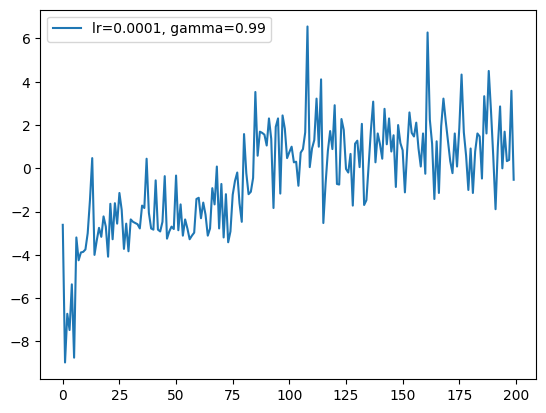

In [20]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()


In [21]:
env = make_env(game_setup_path)

In [22]:
seed = 1337
# Create a grid of learning rates and gammas
learning_rates = [0.001]
gammas = [0.99]

results = {}
for lr in learning_rates:
  results[lr] = {}
  for gamma in gammas:
    seed = seed + 1
    reward_per_episode = train(env, gamma, lr, max_steps=MAX_STEPS, seed=seed, trajectory_policy='boltzmann', label="boltzmann")
    results[lr][gamma] = reward_per_episode

training with gamma 0.99 and learning rate 0.001


/home/jedld/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

0: avg rewards -2.166666666666667 best avg -10@0
best: -2.166666666666667
10: avg rewards -2.638888888888889 best avg -2.166666666666667@0


/home/jedld/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


20: avg rewards -3.0 best avg -2.166666666666667@0
30: avg rewards -3.555555555555555 best avg -2.166666666666667@0
40: avg rewards -0.5555555555555556 best avg -2.166666666666667@0
best: -0.5555555555555556
50: avg rewards -2.083333333333334 best avg -0.5555555555555556@40
60: avg rewards -0.3333333333333333 best avg -0.5555555555555556@40
best: -0.3333333333333333
70: avg rewards 4.666666666666667 best avg -0.3333333333333333@60
best: 4.666666666666667
80: avg rewards 0.638888888888889 best avg 4.666666666666667@70
90: avg rewards -1.4444444444444444 best avg 4.666666666666667@70
100: avg rewards -0.6388888888888887 best avg 4.666666666666667@70
110: avg rewards -1.9999999999999996 best avg 4.666666666666667@70
120: avg rewards 1.1388888888888888 best avg 4.666666666666667@70
130: avg rewards -0.4166666666666664 best avg 4.666666666666667@70
140: avg rewards 1.3611111111111114 best avg 4.666666666666667@70
150: avg rewards 1.7222222222222232 best avg 4.666666666666667@70
160: avg rew

In [23]:
for item in results:
  for gamma in results[item]:
    print(f"lr: {item} gamma: {gamma} rewards: {results[item][gamma]}")

lr: 0.001 gamma: 0.99 rewards: [-2.166666666666667, -2.638888888888889, -3.0, -3.555555555555555, -0.5555555555555556, -2.083333333333334, -0.3333333333333333, 4.666666666666667, 0.638888888888889, -1.4444444444444444, -0.6388888888888887, -1.9999999999999996, 1.1388888888888888, -0.4166666666666664, 1.3611111111111114, 1.7222222222222232, 1.75, -0.11111111111111108, -2.666666666666667, -1.8888888888888886, 1.9166666666666665, -0.9444444444444444, 0.05555555555555571, -1.9999999999999996, 1.8611111111111114, -0.7222222222222221, -2.166666666666667, 0.08333333333333337, 0.9722222222222223, 2.9999999999999996, -0.38888888888888873, 0.027777777777777846, 2.4722222222222223, 0.638888888888889, 0.6111111111111113, -1.472222222222222, 4.305555555555555, -1.5277777777777775, 1.25, 0.861111111111111, -0.41666666666666663, -0.44444444444444464, 2.361111111111111, 2.111111111111111, -1.0277777777777775, 0.5833333333333335, 0.3611111111111111, 2.666666666666667, -0.36111111111111105, -0.055555555

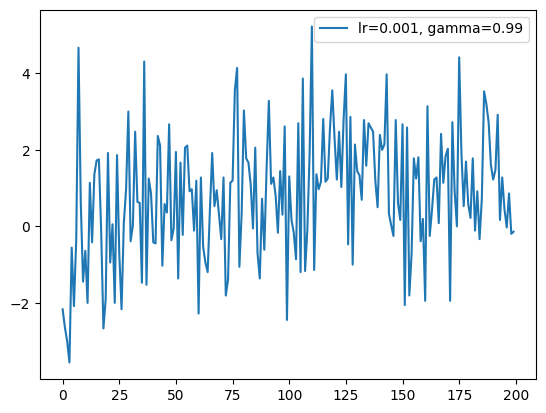

In [24]:
# plot the results
import matplotlib.pyplot as plt

for lr in learning_rates:
    for gamma in gammas:
        plt.plot(results[lr][gamma], label=f"lr={lr}, gamma={gamma}")
plt.legend()
plt.show()

Perform some tests on the trained agent. Show a combat log from a fight against the rules based AI. Define a policy based on the Model.

In [25]:
import os

MAX_EPISODES = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ModelPolicy:
    def __init__(self, weights_file = 'model_best_boltzmann.pt'):
        self.model = QNetwork(device=device)
        self.model.to(device)
        if not os.path.exists(weights_file):
            raise FileNotFoundError(f"Model file {weights_file} not found. Please run dnd_dqn.ipynb notebook to train an agent.")
        self.model.load_state_dict(torch.load(weights_file))

    def action(self, state, info):
        available_moves = info["available_moves"]
        values = torch.stack([self.model(state, move) for move in available_moves])
        for index, v in enumerate(values):
            print(f"{index}: {available_moves[index]} {v.item()}")

        chosen_index = torch.argmax(values).item()
        return available_moves[chosen_index]


In [26]:

env = make_env(game_setup_path)

observation, info = env.reset()

print("=========================================")
print("Battle between an RL agent vs a Rules based AI")
print("=========================================")
model = ModelPolicy()
action = action = model.action(observation, info)

print(f"selected action: {action}")
terminal = False
episode = 0

while not terminal and episode < MAX_EPISODES:
    episode += 1
    observation, reward, terminal, truncated, info = env.step(action)
    print(env.render())
    if not terminal and not truncated:
        episode_name_with_padding = str(episode).zfill(3)

        # display entity healths
        print(f"Turn {info['current_index']}\n")
        print(f"Reward: {reward}\n")
        print(f"health hero: {observation['health_pct']}\n")
        print(f"health enemy: {observation['health_enemy']}\n")
        print(env.render())
        
        action = model.action(observation, info)
        print(f"agent selected action: {action}")

    if terminal or truncated:
        print(f"Reward: {reward}")
        break

Battle between an RL agent vs a Rules based AI
0: (0, (0, 0), (1, 0), 1, 0) -0.7022747993469238
1: (0, (0, 0), (1, 0), 1, 1) -1.0229451656341553
2: (0, (0, 0), (1, 0), 19, 0) -2.4291954040527344
3: (4, (-1, -1), (0, 0), 0, 0) -5.002411842346191
4: (2, (-1, -1), (0, 0), 0, 0) -5.62681770324707
5: (3, (-1, -1), (0, 0), 0, 0) -5.4178009033203125
6: (1, (-1, -1), (0, 0), 0, 0) -1.0996615886688232
7: (1, (-1, 0), (0, 0), 0, 0) -1.3319913148880005
8: (1, (-1, 1), (0, 0), 0, 0) -1.6018273830413818
9: (1, (0, -1), (0, 0), 0, 0) -0.34919100999832153
10: (1, (0, 1), (0, 0), 0, 0) -0.7958550453186035
11: (1, (1, -1), (0, 0), 0, 0) 0.2499685287475586
12: (1, (1, 1), (0, 0), 0, 0) -0.4076462984085083
13: (10, (-1, -1), (0, 0), 0, 0) -0.4558865427970886
14: (12, (-1, -1), (0, 0), 100, 0) -2.2347893714904785
15: (12, (-1, -1), (0, 0), 103, 0) -2.098945379257202
16: (12, (-1, -1), (0, 0), 106, 0) -2.130768299102783
17: (12, (-1, -1), (0, 0), 104, 1) -3.821104049682617
18: (12, (-1, -1), (0, 0), 105, 1

/home/jedld/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:318: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


0: (0, (0, 0), (-1, -1), 1, 0) 5.983529090881348
1: (0, (0, 0), (-1, -1), 1, 1) 5.671953201293945
2: (0, (0, 0), (-1, -1), 19, 0) -0.9191330671310425
3: (4, (-1, -1), (0, 0), 0, 0) -3.101438045501709
4: (2, (-1, -1), (0, 0), 0, 0) -3.1500203609466553
5: (3, (-1, -1), (0, 0), 0, 0) -3.0498647689819336
6: (1, (-1, 0), (0, 0), 0, 0) -0.8409866094589233
7: (1, (-1, 1), (0, 0), 0, 0) -1.5116982460021973
8: (1, (0, -1), (0, 0), 0, 0) -1.3640280961990356
9: (1, (0, 1), (0, 0), 0, 0) -1.6707757711410522
10: (10, (-1, -1), (0, 0), 0, 0) 1.3049921989440918
11: (12, (-1, -1), (0, 0), 100, 0) 0.8406859636306763
12: (12, (-1, -1), (0, 0), 103, 0) 1.1769660711288452
13: (12, (-1, -1), (0, 0), 106, 0) 0.47629469633102417
14: (-1, (0, 0), (0, 0), 0, 0) -4.185558319091797
agent selected action: (0, (0, 0), (-1, -1), 1, 0)
____________
____________
____________
____________
____________
.....E._____
......P_____
   #..._____
  ~~~.._____
~~~...._____
~~....._____
____________
Turn 0

Reward: 0

health h